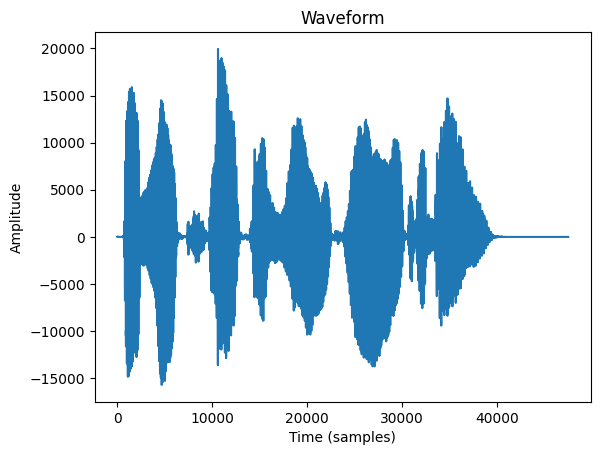

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave

# Open the WAV file
with wave.open("D:/Abhinav/Test/SpeechProcessing/line_3_op.wav", "rb") as wav_file:
    # Extract raw audio data
    signal = wav_file.readframes(-1)
    signal = np.frombuffer(signal, dtype=np.int16)

    # Plot the waveform
    plt.plot(signal)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample
import warnings
warnings.filterwarnings("ignore")

# Step (a): Load the original speech signal and convert to mono if needed
sample_rate, speech_signal = wavfile.read('sample.wav')

# Convert to mono if it's stereo (2D array)
if len(speech_signal.shape) > 1:
    speech_signal = np.mean(speech_signal, axis=1)

# Time vector for original signal
t = np.linspace(0, len(speech_signal) / sample_rate, num=len(speech_signal))

# Function for zero-order hold interpolation
def zero_order_hold(signal, factor):
    return np.repeat(signal, factor)

# Function for linear interpolation
def linear_interpolate(signal, factor):
    # Generate new sample points with factor
    x_new = np.arange(0, len(signal), 1/factor)
    x_old = np.arange(len(signal))
    return np.interp(x_new, x_old, signal)

# Step (a): Plot the original speech signal in the time domain
plt.figure(figsize=(10, 4))
plt.plot(t, speech_signal, color='k')
plt.title('Original Speech Signal (Time Domain)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Step (b): Resample the signal at different sampling rates (8kHz, 16kHz, 44.1kHz)
sample_rates = [8000, 16000, 44100]
resampled_signals = [resample(speech_signal, int(len(speech_signal) * sr / sample_rate)) for sr in sample_rates]

# Step (c): Plot the sampled signals at each sampling rate
for i, sr in enumerate(sample_rates):
    t_resampled = np.linspace(0, len(resampled_signals[i]) / sr, num=len(resampled_signals[i]))
    plt.figure(figsize=(10, 4))
    plt.plot(t_resampled, resampled_signals[i], color='k')  # Use black color for consistency
    plt.title(f'Sampled Speech Signal at {sr} Hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show()

# Step (d): Reconstruct the signals using Zero-Order Hold and Linear Interpolation, and calculate MSE

# Reconstruction and MSE calculation
for i, sr in enumerate(sample_rates):
    factor = sample_rate // sr
    
    # Zero-order hold reconstruction
    reconstructed_zoh = zero_order_hold(resampled_signals[i], factor)
    
    # Linear interpolation reconstruction
    reconstructed_lin = linear_interpolate(resampled_signals[i], factor)
    
    # Truncate reconstructed signals to the length of the original signal for MSE calculation
    reconstructed_zoh = reconstructed_zoh[:len(speech_signal)]
    reconstructed_lin = reconstructed_lin[:len(speech_signal)]
    
    # Step (e): Calculate the Mean Squared Error (MSE)
    mse_zoh = np.mean((speech_signal[:len(reconstructed_zoh)] - reconstructed_zoh) ** 2)
    mse_lin = np.mean((speech_signal[:len(reconstructed_lin)] - reconstructed_lin) ** 2)
    
    # Print MSE for both methods
    print(f'MSE for {sr} Hz - Zero-order hold: {mse_zoh:.4f}, Linear interpolation: {mse_lin:.4f}')


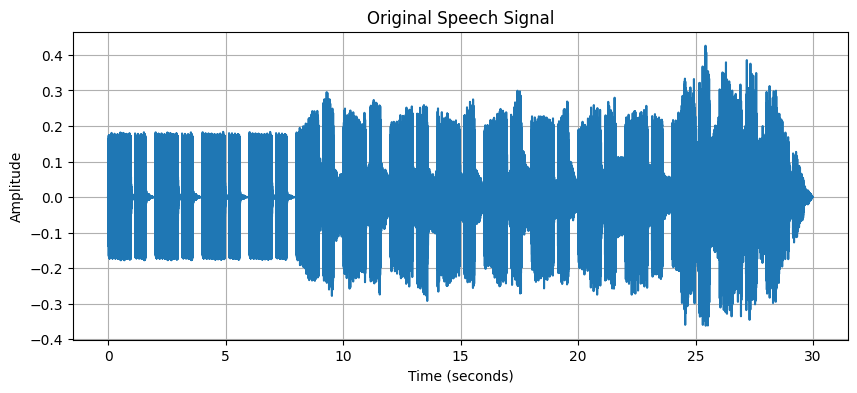

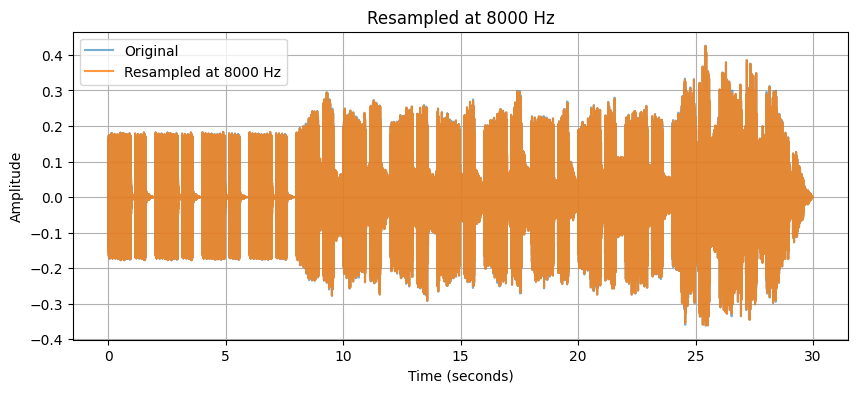

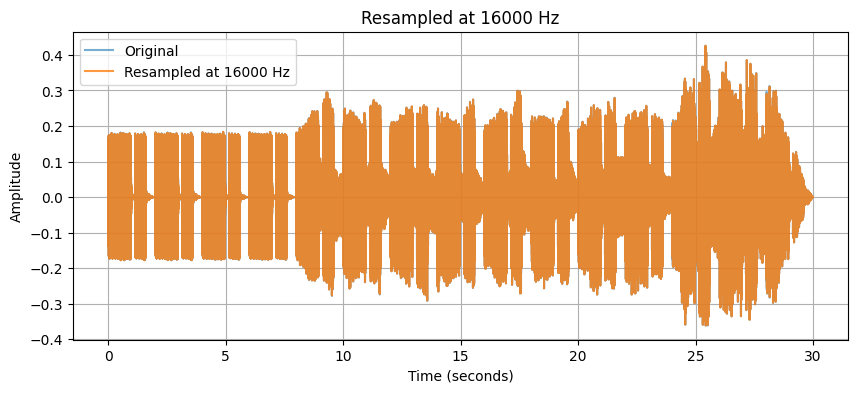

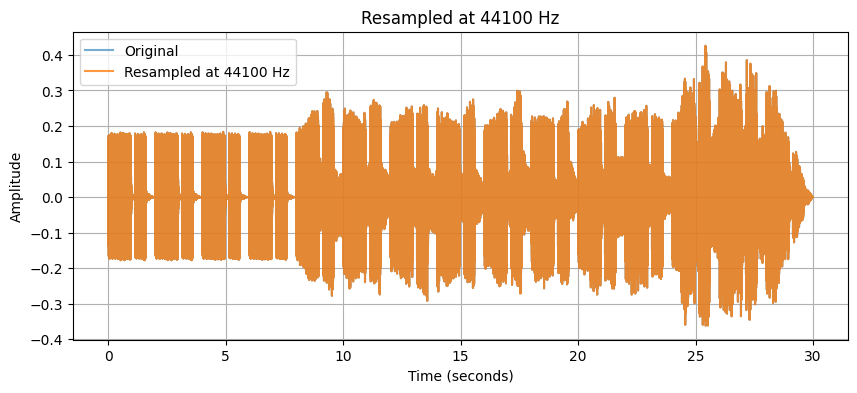

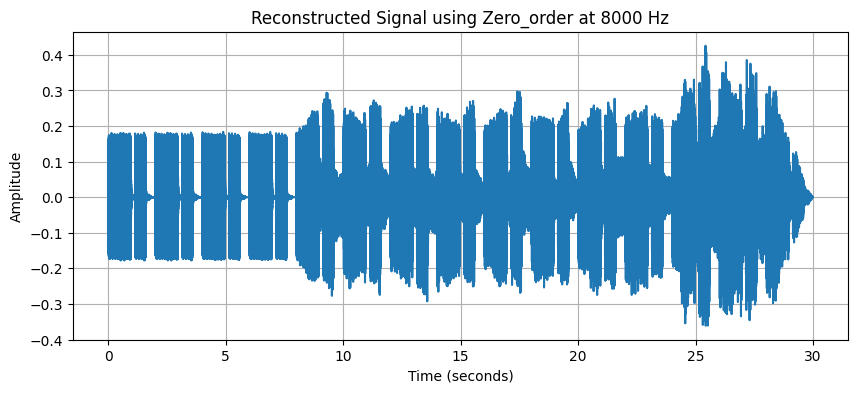

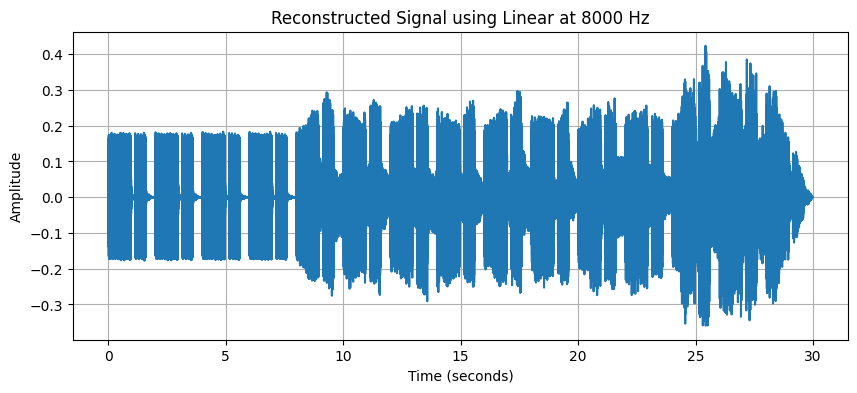

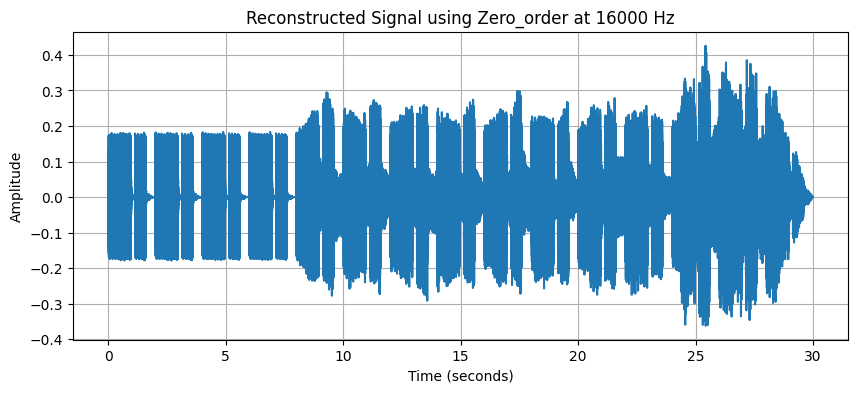

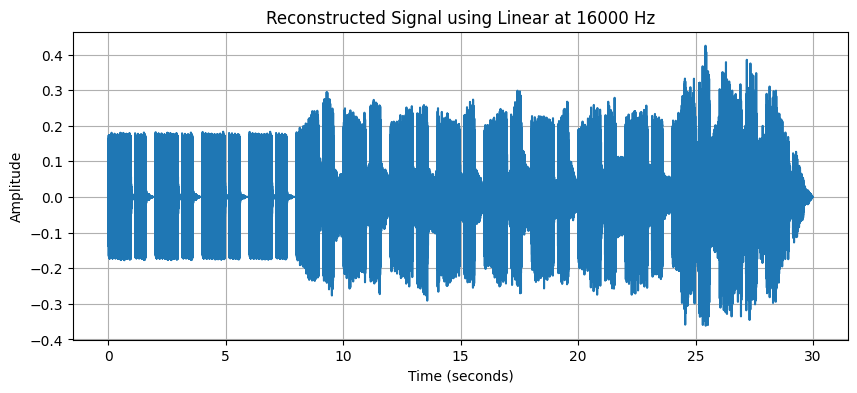

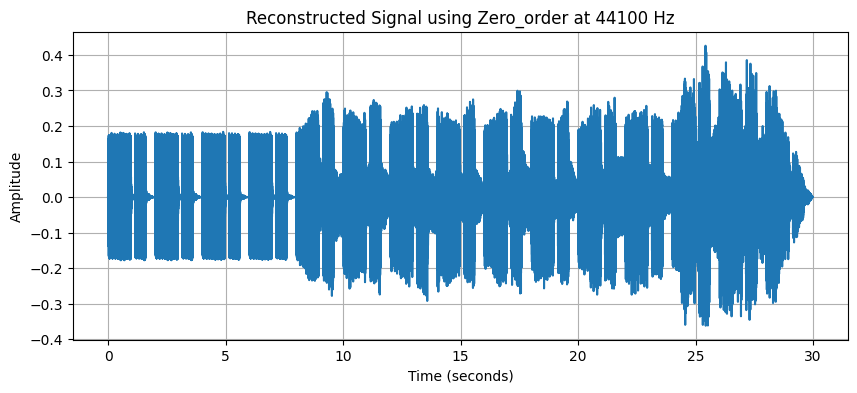

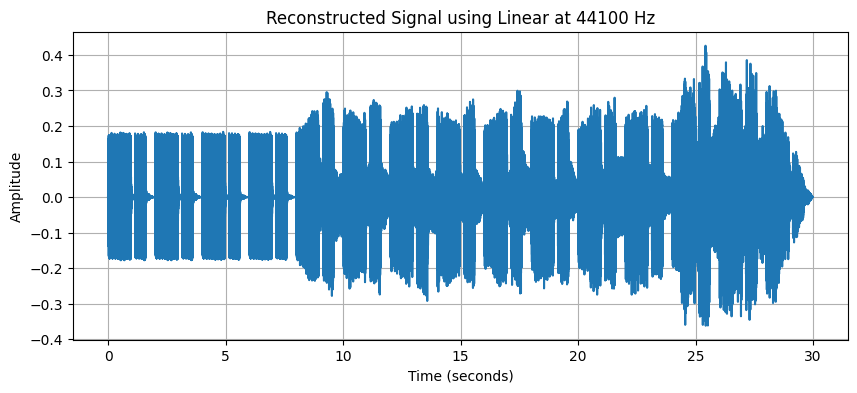

MSE for Zero_order interpolation at 8000 Hz: 0.00029853067826479673
MSE for Linear interpolation at 8000 Hz: 0.0002102853666405714
MSE for Zero_order interpolation at 16000 Hz: 5.4441388783743605e-05
MSE for Linear interpolation at 16000 Hz: 3.2372393310951334e-05
MSE for Zero_order interpolation at 44100 Hz: 1.3349085724006084e-15
MSE for Linear interpolation at 44100 Hz: 1.334910612117885e-15


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import librosa
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

# Step 1: Load Speech Signal and Convert to Mono
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)  # Load and ensure it's mono
    return audio, sr

# Step 2: Plot Original Speech Signal
def plot_signal(audio, sr, title="Original Speech Signal"):
    time = np.linspace(0, len(audio) / sr, len(audio))
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Step 3: Resample the Signal
def resample_signal(audio, original_sr, new_sr):
    number_of_samples = round(len(audio) * float(new_sr) / original_sr)
    resampled_audio = signal.resample(audio, number_of_samples)
    return resampled_audio, new_sr

# Step 4: Plot Resampled Signal
def plot_resampled_signal(original_audio, original_sr, resampled_audio, resampled_sr, title):
    time_original = np.linspace(0, len(original_audio) / original_sr, len(original_audio))
    time_resampled = np.linspace(0, len(original_audio) / original_sr, len(resampled_audio))
    
    plt.figure(figsize=(10, 4))
    plt.plot(time_original, original_audio, label="Original", alpha=0.6)
    plt.plot(time_resampled, resampled_audio, label=f"Resampled at {resampled_sr} Hz", alpha=0.8)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 5: Reconstruct Using Zero-Order Hold and Linear Interpolation
def reconstruct_signal(original_audio, resampled_audio, original_sr, resampled_sr, method='linear'):
    time_original = np.linspace(0, len(original_audio) / original_sr, len(original_audio))
    time_resampled = np.linspace(0, len(original_audio) / original_sr, len(resampled_audio))
    
    if method == 'linear':
        interpolation_func = interp1d(time_resampled, resampled_audio, kind='linear', fill_value="extrapolate")
    elif method == 'zero_order':
        interpolation_func = interp1d(time_resampled, resampled_audio, kind='nearest', fill_value="extrapolate")
    
    reconstructed_audio = interpolation_func(time_original)
    return reconstructed_audio

# Step 6: Calculate MSE between Original and Reconstructed Signal
def calculate_mse(original_audio, reconstructed_audio):
    return mean_squared_error(original_audio, reconstructed_audio)

# Main Execution
file_path = 'D://Abhinav//Test//SpeechProcessing//sample.wav'  # Replace with the actual file path

# Load and Plot Original Signal
original_audio, sr = load_audio(file_path)
plot_signal(original_audio, sr, title="Original Speech Signal")

# Resample at Different Rates
resample_rates = [8000, 16000, 44100]
resampled_signals = {}

for rate in resample_rates:
    resampled_audio, new_sr = resample_signal(original_audio, sr, rate)
    resampled_signals[rate] = resampled_audio
    plot_resampled_signal(original_audio, sr, resampled_audio, new_sr, title=f"Resampled at {rate} Hz")

# Reconstruct Signals using Zero-Order Hold and Linear Interpolation
methods = ['zero_order', 'linear']
mse_results = {}

for rate, resampled_audio in resampled_signals.items():
    mse_results[rate] = {}
    for method in methods:
        reconstructed_audio = reconstruct_signal(original_audio, resampled_audio, sr, rate, method=method)
        mse = calculate_mse(original_audio, reconstructed_audio)
        mse_results[rate][method] = mse
        plot_signal(reconstructed_audio, sr, title=f"Reconstructed Signal using {method.capitalize()} at {rate} Hz")

# Print MSE Results
for rate, method_results in mse_results.items():
    for method, mse_value in method_results.items():
        print(f"MSE for {method.capitalize()} interpolation at {rate} Hz: {mse_value}")

In [ ]:
import speech_recognition as sr
import pyttsx3  # For text-to-speech
import tkinter as tk  # GUI library
from tkinter import messagebox, ttk

# Initialize text-to-speech engine
engine = pyttsx3.init()

# Function to speak a message aloud
def speak_text(text):
    engine.say(text)
    engine.runAndWait()

# GUI to make the app interactive with visual feedback and language support
class SpeechApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Voice Command App")
        self.root.geometry("500x400")

        # Label for feedback
        self.label = tk.Label(root, text="Press the button and speak a command", font=("Helvetica", 14))
        self.label.pack(pady=20)
        
        # Dropdown for language selection
        self.language_label = tk.Label(root, text="Select Language", font=("Helvetica", 12))
        self.language_label.pack(pady=10)
        self.language = tk.StringVar()
        self.language_combobox = ttk.Combobox(root, textvariable=self.language)
        self.language_combobox['values'] = ('en-US', 'es-ES', 'fr-FR', 'de-DE')
        self.language_combobox.current(0)  # Default is English
        self.language_combobox.pack(pady=10)

        # Button to start speech recognition
        self.btn = tk.Button(root, text="🎤 Start Listening", command=self.start_listening, bg="green", fg="white", font=("Helvetica", 16))
        self.btn.pack(pady=20)

        # Status label for dynamic feedback
        self.status_label = tk.Label(root, text="", font=("Helvetica", 12), fg="blue")
        self.status_label.pack(pady=20)

    def start_listening(self):
        recognizer = sr.Recognizer()
        language_code = self.language.get()  # Get selected language
        
        with sr.Microphone() as source:
            self.status_label.config(text="Listening...", fg="blue")
            self.btn.config(bg="orange")  # Change button color when listening
            recognizer.adjust_for_ambient_noise(source)
            audio = recognizer.listen(source)

            try:
                self.status_label.config(text="Recognizing...", fg="orange")
                self.btn.config(bg="yellow")  # Show recognition status visually
                
                # Convert speech to text using the selected language
                text = recognizer.recognize_google(audio, language=language_code)
                self.status_label.config(text=f"Recognized: {text}", fg="green")
                self.btn.config(bg="green")  # Reset button to green after success
                
                # Provide spoken feedback and simulate command execution
                speak_text(f"Command recognized: {text}")
                self.execute_command(text)

            except sr.UnknownValueError:
                self.status_label.config(text="Unclear speech. Please try again.", fg="red")
                self.btn.config(bg="red")  # Visual feedback for error
                speak_text("Sorry, I didn't understand that. Please speak clearly.")
                
            except sr.RequestError:
                self.status_label.config(text="Network error. Check your connection.", fg="red")
                self.btn.config(bg="red")  # Visual feedback for network error
                speak_text("I'm having trouble connecting to the network. Please check your internet.")
                
    def execute_command(self, command_text):
        if "light" in command_text.lower():
            messagebox.showinfo("Smart Device", "Turning on the lights.")
            speak_text("Turning on the lights.")
        elif "music" in command_text.lower():
            messagebox.showinfo("Music", "Playing your favorite song.")
            speak_text("Playing your favorite song.")
        else:
            messagebox.showinfo("Command", f"Executing command: {command_text}")
            speak_text(f"Executing command: {command_text}")

# Create the app window
root = tk.Tk()
app = SpeechApp(root)
root.mainloop()

# lab 4

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.signal import find_peaks

# Step 1: Load a short speech signal
def load_audio(filename, sr=16000, duration=3):
    # Load the audio file
    y, sr = librosa.load(filename, sr=sr, duration=duration)
    return y, sr

# Step 2: LPC analysis to extract LPC coefficients
def lpc_analysis(signal, order):
    """ 
    LPC analysis to get LPC coefficients. 
    Order typically ranges from 8 to 16 for speech signals.
    """
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order+1]
    A = np.zeros(order)
    E = np.zeros(order+1)
    
    # Initial error
    E[0] = R[0]
    
    for i in range(1, order+1):
        k = R[i] - np.dot(A[:i-1], R[1:i][::-1])
        k /= E[i-1]
        A[i-1] = k
        
        if i > 1:
            A[:i-1] -= k * A[:i-1][::-1]
        
        E[i] = (1 - k**2) * E[i-1]
    
    return np.concatenate([[1], -A]), E[-1]

# Step 3: Reconstruct the signal using LPC coefficients
def reconstruct_signal(lpc_coeffs, signal):
    """ Reconstruct the signal using the inverse of LPC filtering """
    # Apply inverse filter using LPC coefficients
    reconstructed_signal = lfilter([0] + -lpc_coeffs[1:], [1], signal)
    return reconstructed_signal

# Step 4: Estimate formant frequencies from LPC coefficients
def estimate_formants(lpc_coeffs, sr):
    """ Formants are peaks in the LPC spectrum """
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]
    
    angles = np.angle(roots)
    freqs = np.sort(angles * (sr / (2 * np.pi)))
    
    return freqs[:4]  # Return the first four formants

# Step 5: Plotting the original and reconstructed signals, and formants
def plot_results(original_signal, reconstructed_signal, formants, sr):
    # Time axis for the signals
    t = np.arange(len(original_signal)) / sr
    
    plt.figure(figsize=(15, 8))
    
    # Plot original signal
    plt.subplot(2, 1, 1)
    plt.plot(t, original_signal, label='Original Signal')
    plt.plot(t, reconstructed_signal, label='Reconstructed Signal', alpha=0.7)
    plt.title("Original and Reconstructed Signal")
    plt.legend()

    # Plot formants as a frequency response plot
    plt.subplot(2, 1, 2)
    plt.stem(formants, np.ones(len(formants)), 'r', markerfmt='ro', basefmt=" ")
    plt.title("Formant Frequencies")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()

# Step 6: Main function to execute LPC analysis
def lpc_model(filename, order=12, duration=3):
    # Load audio
    signal, sr = load_audio(filename, duration=duration)
    
    # Normalize the signal
    signal = signal / np.max(np.abs(signal))
    
    # LPC analysis
    lpc_coeffs, error = lpc_analysis(signal, order)
    
    # Reconstruct signal
    reconstructed_signal = reconstruct_signal(lpc_coeffs, signal)
    
    # Estimate formants
    formants = estimate_formants(lpc_coeffs, sr)
    
    # Plot results
    plot_results(signal, reconstructed_signal, formants, sr)
    
    # Return the LPC coefficients and formants for further analysis
    return lpc_coeffs, formants


# Specify the filename here as a separate variable
filename = "Jazz.wav"  # Replace with your audio file path

# Call the LPC model with the specified filename
lpc_coeffs, formants = lpc_model(filename, order=12, duration=10)